# Batch 3 - Developing Daily Load Profiles

## Install required libraries

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=b894944aadf0d0d07f31a63ed153a97007d30851d86d124a1a985dda928c1188
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


## Import required libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format, min, max, hour, avg, to_timestamp
import matplotlib.pyplot as plt
from pyspark.sql.types import StructType
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F

## Import data

In [4]:
spark = SparkSession.builder.appName("TimeSeriesBatchProcessing").getOrCreate()

In [5]:
data = '/content/drive/My Drive/Power_flow_data/2010-07-02.csv'

In [6]:
df = spark.read.csv(data, header=True)

## Quick EDA

### Data understanding

In [7]:
min_interval = 5
time_in_minutes = (df.select('Timestamp').distinct().count()) * 5
hours = time_in_minutes // 60
minutes = time_in_minutes % 60
min_timestamp = df.agg(min(date_format("Timestamp", "HH:mm:ss"))).collect()[0][0]
max_timestamp = df.agg(max(date_format("Timestamp", "HH:mm:ss"))).collect()[0][0]

print("Number of rows = ", str(df.count()))
print("Number of power lines = ", str(df.select('PowerLineID').distinct().count()))
print("Time measured = ",str(hours) + " hours and ", str(minutes), " minutes")
print("Min time = ", str(min_timestamp))
print("Max time = ", str(max_timestamp))

df.show()

Number of rows =  551808
Number of power lines =  1916
Time measured =  24 hours and  0  minutes
Min time =  00:00:00
Max time =  23:55:00
+-------------------+---------+-----------+--------------+
|          Timestamp|DayOfWeek|PowerLineID|PowerFlowValue|
+-------------------+---------+-----------+--------------+
|2010-07-02 00:00:00|   Friday|       1215|        -150.0|
|2010-07-02 00:00:00|   Friday|        182|           0.0|
|2010-07-02 00:00:00|   Friday|        577|           0.0|
|2010-07-02 00:00:00|   Friday|       1456|       -125.53|
|2010-07-02 00:00:00|   Friday|       1405|         81.66|
|2010-07-02 00:00:00|   Friday|       1780|         10.97|
|2010-07-02 00:00:00|   Friday|       1182|           0.0|
|2010-07-02 00:00:00|   Friday|        186|           0.0|
|2010-07-02 00:00:00|   Friday|       1749|           0.0|
|2010-07-02 00:00:00|   Friday|       1390|        -26.02|
|2010-07-02 00:00:00|   Friday|        163|       -328.53|
|2010-07-02 00:00:00|   Friday|    

In [8]:
df.printSchema()

root
 |-- Timestamp: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PowerLineID: string (nullable = true)
 |-- PowerFlowValue: string (nullable = true)



In [9]:
df = df.withColumn('PowerFlowValue', col('PowerFlowValue').cast('float'))
df = df.withColumn('Timestamp', to_timestamp(col('Timestamp'), 'yyyy-MM-dd HH:mm:ss'))

In [10]:
specific_powerline_df = df.filter(df['PowerLineID']==1215)
specific_powerline_df.count()

288

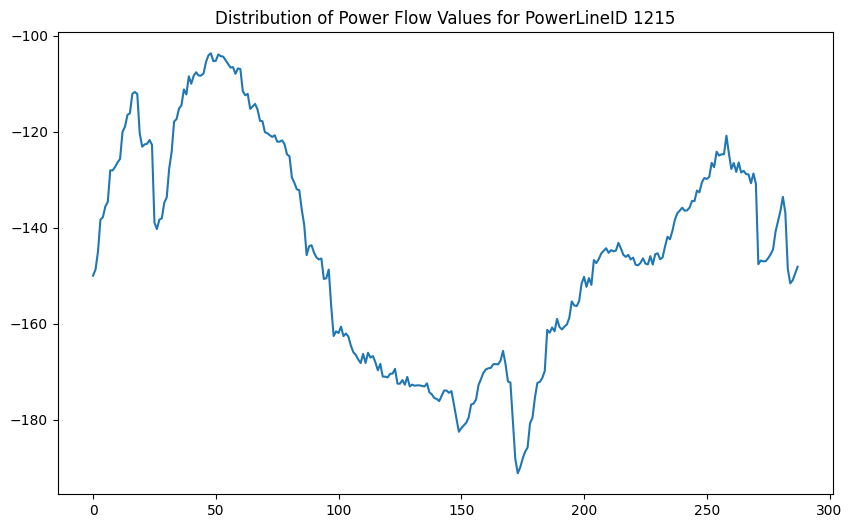

In [12]:
power_flow_values = specific_powerline_df.select('PowerFlowValue').rdd.flatMap(lambda x: x).collect()

# Plot the line chart showing the distribution
plt.figure(figsize=(10, 6))
plt.plot(power_flow_values)
plt.title(f'Distribution of Power Flow Values for PowerLineID 1215')
plt.show()

## Normalization of Power Flow Values and data transformation

In [11]:
from pyspark.ml.feature import MinMaxScaler

In [12]:
# Create a Spark session
spark = SparkSession.builder.appName("PowerFlowNormalization").getOrCreate()

data_path = '/content/drive/My Drive/Power_flow_data/2010-07-02.csv'
df = spark.read.csv(data_path, header=True)

df = df.withColumn('PowerFlowValue', col('PowerFlowValue').cast('float'))
df = df.withColumn('Timestamp', to_timestamp(col('Timestamp'), 'yyyy-MM-dd HH:mm:ss'))

# Select only the relevant feature for normalization
assembler = VectorAssembler(inputCols=["PowerFlowValue"], outputCol="features")
df = assembler.transform(df)

# Initialize the MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="NormalizedPowerFlowValue")

# Compute summary statistics and generate the MinMaxScalerModel
scaler_model = scaler.fit(df)

# Transform the data
df_normalized = scaler_model.transform(df)

# Show the normalized DataFrame
df_normalized.select("NormalizedPowerFlowValue").show()

+------------------------+
|NormalizedPowerFlowValue|
+------------------------+
|    [0.41151229454149...|
|    [0.4660557661722082]|
|    [0.4660557661722082]|
|    [0.4204101533240602]|
|    [0.4957492334595968]|
|    [0.4700447121612323]|
|    [0.4660557661722082]|
|    [0.4660557661722082]|
|    [0.4660557661722082]|
|    [0.45659429179354...|
|    [0.34659465505049...|
|    [0.4720628206809243]|
|    [0.4640922011588246]|
|    [0.5406676000193352]|
|    [0.4660557661722082]|
|    [0.4493291015387891]|
|    [0.4363295741334688]|
|    [0.4660557661722082]|
|    [0.4372931760204563]|
|    [0.46258680139036...|
+------------------------+
only showing top 20 rows



In [13]:
from pyspark.ml.functions import vector_to_array

# Convert vector column to array
df_normalized = df_normalized.withColumn("NormalizedPowerFlowArray", vector_to_array("NormalizedPowerFlowValue"))

# Extract individual values from the array into separate columns
df_normalized = df_normalized.withColumn("NormalizedPowerFlowValue", col("NormalizedPowerFlowArray")[0])

# Drop the intermediate array column
df_normalized = df_normalized.drop("NormalizedPowerFlowArray")

In [14]:
# Show the modified DataFrame with actual values
df_normalized.show()

+-------------------+---------+-----------+--------------+--------------------+------------------------+
|          Timestamp|DayOfWeek|PowerLineID|PowerFlowValue|            features|NormalizedPowerFlowValue|
+-------------------+---------+-----------+--------------+--------------------+------------------------+
|2010-07-02 00:00:00|   Friday|       1215|        -150.0|            [-150.0]|     0.41151229454149374|
|2010-07-02 00:00:00|   Friday|        182|           0.0|               [0.0]|      0.4660557661722082|
|2010-07-02 00:00:00|   Friday|        577|           0.0|               [0.0]|      0.4660557661722082|
|2010-07-02 00:00:00|   Friday|       1456|       -125.53|[-125.52999877929...|      0.4204101533240602|
|2010-07-02 00:00:00|   Friday|       1405|         81.66| [81.66000366210938]|      0.4957492334595968|
|2010-07-02 00:00:00|   Friday|       1780|         10.97|[10.970000267028809]|      0.4700447121612323|
|2010-07-02 00:00:00|   Friday|       1182|           0

### Visualize a selected powerline for normalized values

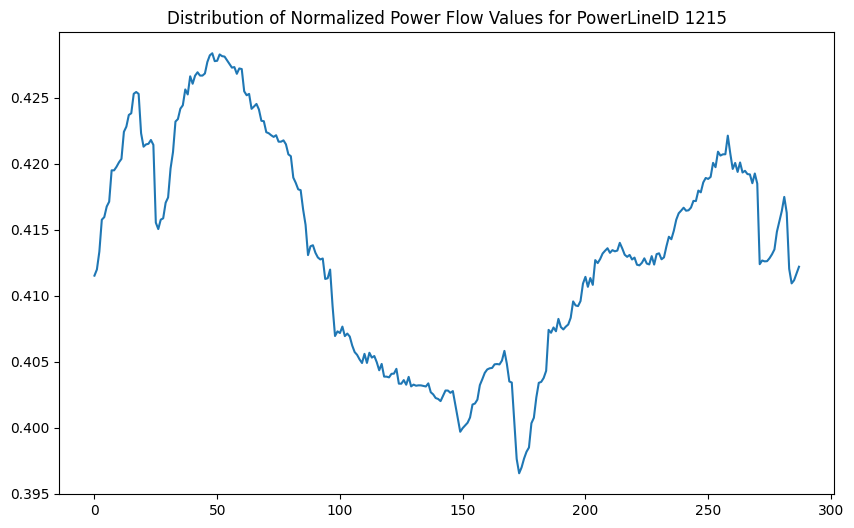

In [48]:
specific_powerline_df = df_normalized.filter(df_normalized['PowerLineID']==1215)
specific_powerline_df.count()
power_flow_values = specific_powerline_df.select('NormalizedPowerFlowValue').rdd.flatMap(lambda x: x).collect()

# Plot the line chart showing the distribution
plt.figure(figsize=(10, 6))
plt.plot(power_flow_values)
plt.title(f'Distribution of Normalized Power Flow Values for PowerLineID 1215')
plt.show()

In [1]:
## creating hourly averages

In [15]:
# Group by hour and calculate the average power flow value for each hour
hourly_avg_df = (
    df_normalized
    .withColumn("Hour", hour("Timestamp"))
    .groupBy("PowerLineID", "Hour")
    .agg(avg("NormalizedPowerFlowValue").alias("AveragePowerFlow"))
)

In [16]:
hourly_avg_df.show()

+-----------+----+-------------------+
|PowerLineID|Hour|   AveragePowerFlow|
+-----------+----+-------------------+
|         19|   0| 0.8974188719494499|
|         73|   0|0.38417389318839423|
|       1412|   0|0.46555608735347537|
|        754|   0|0.47770928190308526|
|        771|   0|0.49422231778901354|
|        450|   0|0.44345567876212977|
|        860|   0| 0.4645715776902519|
|        884|   0|0.41968563386707786|
|        542|   0|0.46995653347391625|
|       1888|   0|0.48137036097520247|
|        394|   0| 0.3155572988905159|
|       1747|   1| 0.4660557661722082|
|        419|   1|0.45516525295703847|
|         69|   1|0.49712645486987145|
|        787|   1| 0.4660557661722082|
|         37|   1|0.38028039959248056|
|        409|   1| 0.5248481747423156|
|       1143|   1| 0.4660557661722082|
|       1363|   1| 0.4660557661722082|
|       1594|   1| 0.4267281049922473|
+-----------+----+-------------------+
only showing top 20 rows



In [65]:
hourly_avg_df.select('PowerLineID').distinct().count()

1916

In [66]:
hourly_avg_df.select('Hour').distinct().count()

24

In [70]:
hourly_avg_df = hourly_avg_df.sort('PowerLineID', 'Hour')

In [76]:
specific_df = hourly_avg_df.filter(hourly_avg_df['PowerLineID']==1215)

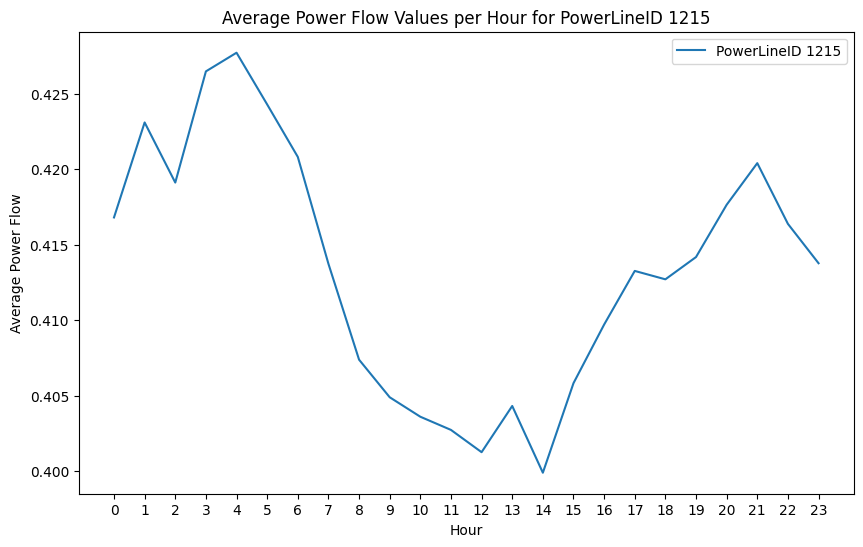

In [77]:
powerline_id = "1215"

# Extract Hour and AveragePowerFlow columns for plotting
hours = [row["Hour"] for row in specific_df.select("Hour").collect()]
average_power_flow_values = [row["AveragePowerFlow"] for row in specific_df.select("AveragePowerFlow").collect()]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(hours, average_power_flow_values, label=f"PowerLineID {powerline_id}")
plt.title(f"Average Power Flow Values per Hour for PowerLineID {powerline_id}")
plt.xlabel("Hour")
plt.ylabel("Average Power Flow")
plt.xticks(hours)
plt.legend()
plt.show()

In [20]:
# Specify the columns to be used as features
feature_columns = ['AveragePowerFlow']

# Create a vector assembler
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the DataFrame to include the features vector
feature_df = vector_assembler.transform(hourly_avg_df)

# Define the number of clusters
num_clusters = 50

# Initialize the KMeans model
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=num_clusters, seed=1)

# Fit the model to the data
model = kmeans.fit(feature_df)

# Make predictions
predictions = model.transform(feature_df)

In [54]:
specific_powerline_cluster = predictions.filter(predictions['PowerLineID'] == 1215)
pd_df = specific_powerline_cluster.toPandas()

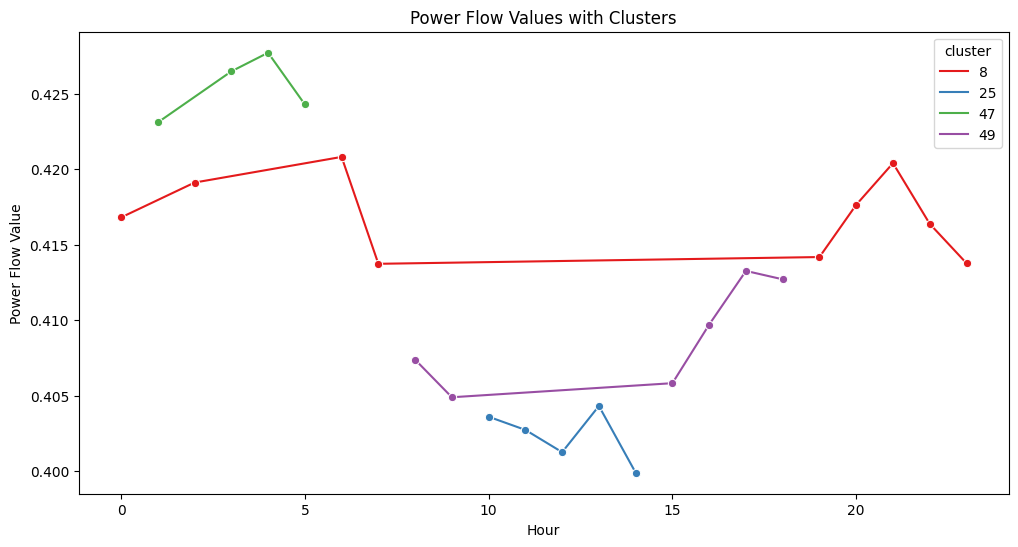

In [55]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(x="Hour", y="AveragePowerFlow", hue="cluster", data=pd_df, palette = "Set1", marker = "o")
plt.title(f"Power Flow Values with Clusters")
plt.xlabel("Hour")
plt.ylabel("Power Flow Value")
plt.show()

In [ ]:
# Get the count of distinct clusters for each PowerLineID
distinct_clusters_df = predictions.groupBy("PowerLineID").agg(
    F.countDistinct("cluster").alias("distinct_clusters")
)

# Find the powerline with the minimum count of clusters
min_clusters_powerline = distinct_clusters_df.orderBy("distinct_clusters").first()

# Find the powerline with the maximum count of clusters
max_clusters_powerline = distinct_clusters_df.orderBy(F.desc("distinct_clusters")).first()

In [48]:
print('Minimum number of clusters in powerlines =', str(min_clusters_powerline['distinct_clusters']))
print('Maximum number of clusters in powerlines =', str(max_clusters_powerline['distinct_clusters']))

Minimum number of clusters in powerlines = 1
Maximum number of clusters in powerlines = 18


In [ ]:
distinct_clusters_pd = distinct_clusters_df.toPandas()

<Axes: >

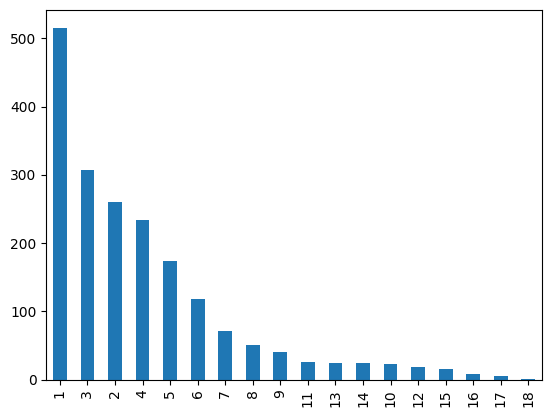

In [53]:
distinct_clusters_pd.distinct_clusters.value_counts().plot(kind='bar')
plt.show()

## Example usage from trained and saved models

In [63]:
def process_csv(spark, data_path):

    # Read CSV data
    df = spark.read.csv(data_path, header=True)

    # Cast PowerFlowValue to float and Timestamp to timestamp type
    df = df.withColumn('PowerFlowValue', col('PowerFlowValue').cast('float'))
    df = df.withColumn('Timestamp', to_timestamp(col('Timestamp'), 'yyyy-MM-dd HH:mm:ss'))

    # Select relevant feature for normalization
    assembler = VectorAssembler(inputCols=["PowerFlowValue"], outputCol="features")
    df = assembler.transform(df)

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler(inputCol="features", outputCol="NormalizedPowerFlowValue")

    # Compute summary statistics and generate the MinMaxScalerModel
    scaler_model = scaler.fit(df)

    # Transform the data
    df_normalized = scaler_model.transform(df)

    # Convert vector column to array
    df_normalized = df_normalized.withColumn("NormalizedPowerFlowArray", vector_to_array("NormalizedPowerFlowValue"))

    # Extract individual values from the array into separate columns
    df_normalized = df_normalized.withColumn("NormalizedPowerFlowValue", col("NormalizedPowerFlowArray")[0])

    # Drop the intermediate array column
    df_normalized = df_normalized.drop("NormalizedPowerFlowArray")

    # Group by hour and calculate the average power flow value for each hour
    hourly_avg_df = (
        df_normalized
        .withColumn("Hour", hour("Timestamp"))
        .groupBy("PowerLineID", "Hour")
        .agg(avg("NormalizedPowerFlowValue").alias("AveragePowerFlow"))
    )

    # Sort the resulting DataFrame
    hourly_avg_df = hourly_avg_df.sort('PowerLineID', 'Hour')

    return hourly_avg_df

In [65]:
from pyspark.ml.clustering import KMeansModel

spark = SparkSession.builder.appName("KMeansPrediction").getOrCreate()

test_model = KMeansModel.load('/content/drive/My Drive/kmeans_models/model_2010-07-22')
processed_df = process_csv(spark, '/content/drive/My Drive/Power_flow_data/2010-07-22.csv')

feature_columns = ['AveragePowerFlow']
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
feature_df = vector_assembler.transform(processed_df)

test = test_model.transform(feature_df)

In [95]:
selected_powerline = test.filter(test['PowerLineID'] == 0)

In [96]:
pd_df = selected_powerline.toPandas()

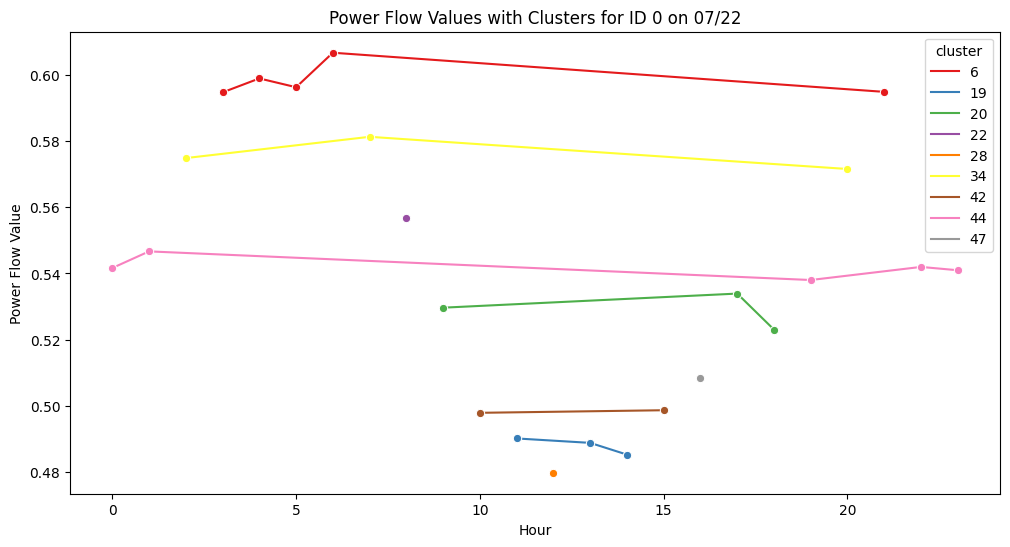

In [97]:
plt.figure(figsize=(12, 6))
sns.lineplot(x="Hour", y="AveragePowerFlow", hue="cluster", data=pd_df, palette = "Set1", marker = "o")
plt.title(f"Power Flow Values with Clusters for ID 0 on 07/22")
plt.xlabel("Hour")
plt.ylabel("Power Flow Value")
plt.show()